<a href="https://colab.research.google.com/github/phixerino/cloud-segmentation/blob/main/notebooks/sentinel_segmentation_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentinel-2 Cloud segmentation inference

In [1]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 8.5 MB/s eta 0:00:00


In [2]:
import os
import onnxruntime as rt
import numpy as np
import cv2
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

IMG_FORMATS = 'bmp', 'jpeg', 'jpg', 'png', 'tif', 'tiff', 'webp', 'pfm'

Mounted at /content/drive


Settings

In [3]:
model_file = '/content/drive/MyDrive/weights/DeepLabV3Plus_resnet101_1678896432.onnx'
source = '/content/drive/MyDrive/data'
input_width, input_height = 224, 224
bands = [3, 2, 1, 7]  # image bands from source images to model input
bands_post = [0, 1, 2]  # image bands from model input to show/save (should be in BGR)
max_pixel_value = 1.  # maximum possible pixel value of input images
normalize_mean = [0.485, 0.456, 0.406, 0.388]  # mean values for each channel for normalization
normalize_std = [0.229, 0.224, 0.225, 0.264]  # std values for each channel for normalization
sigmoid_output = False  # sigmoid model output, otherwise logits
binary_threshold = 0.5 if sigmoid_output else 0.0

Load model

In [4]:
session = rt.InferenceSession(model_file, providers=['CPUExecutionProvider'])

Load images paths

In [5]:
file_paths = []
if os.path.isdir(source):  # source is folder
    for file_name in os.listdir(source):
        file_path = os.path.join(source, file_name)
        if os.path.isfile(file_path):
            file_paths.append(file_path)
elif os.path.isfile(source):  # source is file
    file_paths.append(source)
    
file_paths

['/content/drive/MyDrive/data/test_subscene.npy']

Load and preprocess methods

In [6]:
def preprocess_img(img, normalize_mean, normalize_std, max_pixel_value=1.):
    assert img.ndim == 3
    img = (img - np.array(normalize_mean) * max_pixel_value) / (np.array(normalize_std) * max_pixel_value)  # normalize
    img = img.transpose(2, 0, 1)  # HWC to CHW
    img = np.expand_dims(img, axis=0)  # CHW to BCHW
    img = img.astype(np.float32)
    return img

def load_image(img_filepath):
    img_ext = os.path.splitext(img_filepath)[1]
    if img_ext in IMG_FORMATS:
        img = cv2.imread(img_filepath)
    elif img_ext == '.npy':
        img = np.load(img_filepath)
    else:
        img = None
    return img

def get_tiles(img, tile_h, tile_w, bands):
    tiles = []
    img_h, img_w = img.shape[:2]
    tile_y, tile_x = 0, 0
    while tile_y + tile_h <= img_h:
        tiles.append(img[tile_y:tile_y+tile_h, tile_x:tile_x+tile_w, bands])
        tile_x += tile_w
        if tile_x + tile_w > img_w:
            tile_x = 0
            tile_y += tile_h
    return tiles

Run prediction

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 1


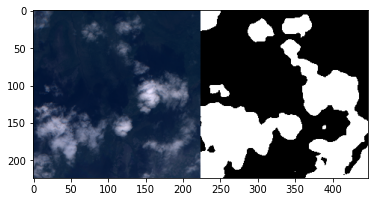

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 2


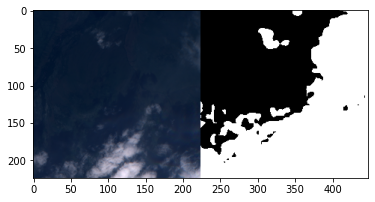

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 3


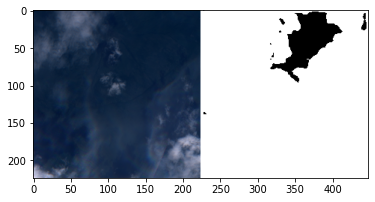

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 4


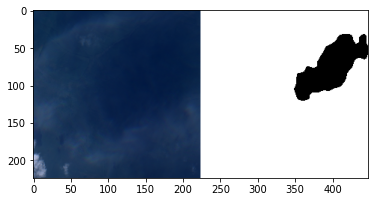

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 5


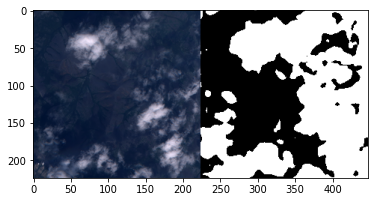

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 6


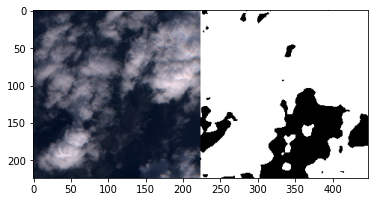

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 7


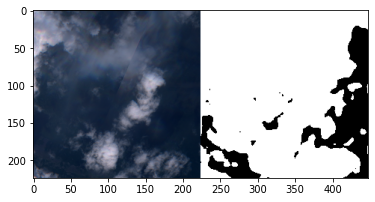

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 8


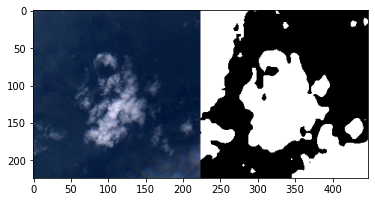

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 9


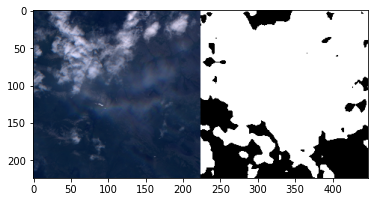

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 10


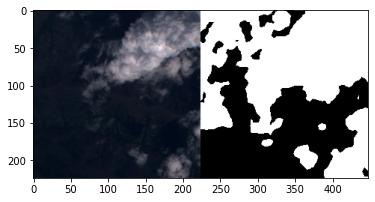

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 11


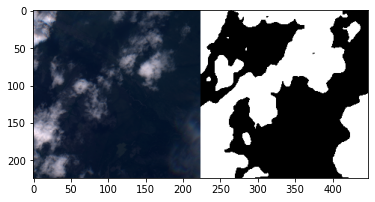

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 12


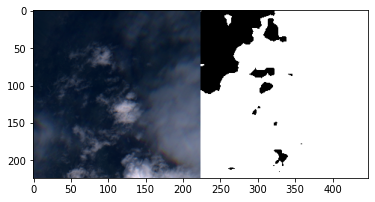

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 13


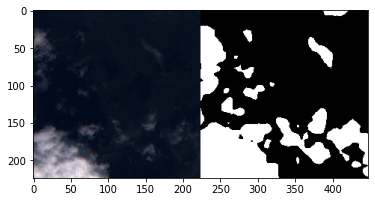

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 14


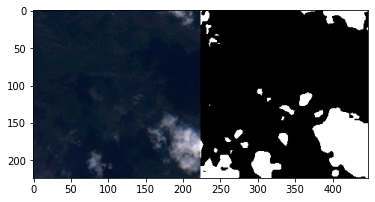

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 15


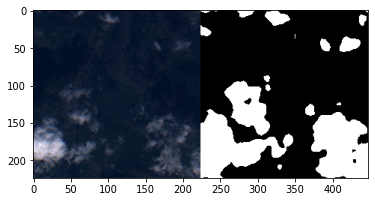

image: /content/drive/MyDrive/data/test_subscene.npy, tile: 16


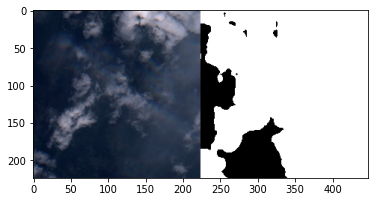

In [7]:
for file_path in file_paths:
    img = load_image(file_path)  # load image
    if img is not None:
        tiles = get_tiles(img, input_height, input_width, bands)  # get tiles from image
        for i, tile in enumerate(tiles):
            tile_name = f'image: {file_path}, tile: {i+1}'
            print(tile_name)

            tile = preprocess_img(tile, normalize_mean, normalize_std, max_pixel_value)  # preprocess tile
            
            pred = session.run([session.get_outputs()[0].name], {session.get_inputs()[0].name: tile})[0]  # predict

            # postprocess
            pred_img = (pred>binary_threshold).squeeze() * 255
            pred_img = pred_img.astype(np.uint8)
            pred_img = cv2.cvtColor(pred_img, cv2.COLOR_GRAY2BGR)

            tile_img = tile.squeeze().transpose(1, 2, 0)  # BCHW to HWC
            tile_img = tile_img[..., bands_post]  # channels to show
            tile_img = cv2.normalize(tile_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)  # normalize to 0-255 values

            # plot
            show_img = np.concatenate((tile_img, pred_img), axis=1)
            plt.imshow(show_img)
            plt.show()
